In [114]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
import librosa
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import Image
import warnings; warnings.filterwarnings('ignore') #matplot lib complains about librosa

In [115]:
#port warnings; warnings.filterwarnings('ignore') #matplot lib complains about librosa
# RAVDESS native sample rate is 48k
sample_rate = 48000

# Mel Spectrograms are not directly used as a feature in this model
# Mel Spectrograms are used in calculating MFCCs, which are a higher-level representation of pitch transition
# MFCCs work better - left the mel spectrogram function here in case anyone wants to experiment
def feature_melspectrogram(
    waveform, 
    sample_rate,
    fft = 1024,
    winlen = 512,
    window='hamming',
    hop=256,
    mels=128,
    ):
    
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram = librosa.feature.melspectrogram(
        y=waveform, 
        sr=sample_rate, 
        n_fft=fft, 
        win_length=winlen, 
        window=window, 
        hop_length=hop, 
        n_mels=mels, 
        fmax=sample_rate/2)
    
    # convert from power (amplitude**2) to decibels
    # necessary for network to learn - doesn't converge with raw power spectrograms 
    melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
    
    return melspectrogram

def feature_mfcc(
    waveform, 
    sample_rate,
    n_mfcc = 40,
    fft = 1024,
    winlen = 512,
    window='hamming',
    #hop=256, # increases # of time steps; was not helpful
    mels=128
    ):

    # Compute the MFCCs for all STFT frames 
    # 40 mel filterbanks (n_mfcc) = 40 coefficients
    mfc_coefficients=librosa.feature.mfcc(
        y=waveform, 
        sr=sample_rate, 
        n_mfcc=n_mfcc,
        n_fft=fft, 
        win_length=winlen, 
        window=window, 
        #hop_length=hop, 
        n_mels=mels, 
        fmax=sample_rate/2
        ) 

    return mfc_coefficients

def get_features(waveforms, features, samplerate):

    # initialize counter to track progress
    file_count = 0

    # process each waveform individually to get its MFCCs
    for waveform in waveforms:
        mfccs = feature_mfcc(waveform, sample_rate)
        features.append(mfccs)
        file_count += 1
        # print progress 
        print('\r'+f' Processed {file_count}/{len(waveforms)} waveforms',end='')
    
    # return all features from list of waveforms
    return features

def get_waveforms(file):
    
    # load an individual sample audio file
    # read the full 3 seconds of the file, cut off the first 0.5s of silence; native sample rate = 48k
    # don't need to store the sample rate that librosa.load returns
    waveform, _ = librosa.load(file, duration=3, offset=0.5, sr=sample_rate)
    
    # make sure waveform vectors are homogenous by defining explicitly
    waveform_homo = np.zeros((int(sample_rate*3,)))
    waveform_homo[:len(waveform)] = waveform
    
    # return a single file's waveform                                      
    return waveform_homo
    
# RAVDESS dataset emotions
# shift emotions left to be 0 indexed for PyTorch
emotions_dict ={
 '''
    '0':'surprised',
    '1':'neutral',
    '2':'calm',
    '3':'happy',
    '4':'sad',
    '5':'angry',
    '6':'fearful',
    '7':'disgust'  '''

   
    '0':'neutral',
    '1':'calm',
    '2':'happy',
    '3':'sad',
    '4':'angry',
    '5':'fearful',
    

}

# Additional attributes from RAVDESS to play with
emotion_attributes = {
    '01': 'normal',
    '02': 'strong'
}

In [116]:
# path to data for glob
data_path = 'ravadessspeechsong'

##'RAVDESS dataset/Actor_*/*.wav'
dir_list = os.listdir(data_path)
dir_list.sort()
dir_list

['.ipynb_checkpoints',
 'Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [117]:
def load_data():
  # features and labels
  emotions = []
  # raw waveforms to augment later
  waveforms = []
  # extra labels
  intensities, genders = [],[]
  # progress counter
  file_count = 0
  for i in dir_list:
    #print(i)
    file_name = os.listdir(data_path + '/' +i+'/')
    for file in file_name:
     # print(file)
      #print(file_name)
      if file =='.ipynb_checkpoints' : continue
      file=data_path + '/' +i+'/'+file
      nm = file.split('.')[0].split('-')
      # get emotion label from the sample's file
      emotion = int(nm[2])
      #  move surprise to 0 for cleaner behaviour with PyTorch/0-indexing
      if emotion == 1:  emotion = 0
      if emotion == 2:  emotion = 1
      if emotion == 3:  emotion = 2
      if emotion == 4:  emotion = 3
      if emotion == 5:  emotion = 4
      if emotion == 6:  emotion = 5
      if emotion == 7:  continue
      if emotion == 8:  continue      # surprise is now at 0 index; other emotion indeces unchanged

      # can convert emotion label to emotion string if desired, but
      # training on number is better; better convert to emotion string after predictions are ready
      # emotion = emotions_dict[str(emotion)]
            
      # get other labels we might want
      #intensity = emotion_attributes[int(nm[3])]
      if nm[3] == '01':
            intensity = 0
      else:
            intensity = 1
      # even actors are female, odd are male
      if (int((file.split("-")[6]).split(".")[0]))%2==0: 
          gender = 'female' 
      else: 
          gender = 'male'
                
      # get waveform from the sample
      waveform = get_waveforms(file)
            
      # store waveforms and labels
      waveforms.append(waveform)
      emotions.append(emotion)
      intensities.append(intensity) # store intensity in case we wish to predict
      genders.append(gender) # store gender in case we wish to predict 
            
      file_count += 1
      # keep track of data loader's progress
      print('\r'+f' Processed {file_count}/{1440} audio samples',end='')
  

  return waveforms, emotions, intensities, genders
      #****************************#

In [118]:
# load data 
# init explicitly to prevent data leakage from past sessions, since load_data() appends
waveforms, emotions, intensities, genders = [],[],[],[]
waveforms, emotions, intensities, genders = load_data()

 Processed 2068/1440 audio samples

In [119]:
print(f'Waveforms set: {len(waveforms)} samples')
# we have 1440 waveforms but we need to know their length too; should be 3 sec * 48k = 144k
print(f'Waveform signal length: {len(waveforms[0])}')
print(f'Emotions set: {len(emotions)} sample labels')

Waveforms set: 2068 samples
Waveform signal length: 144000
Emotions set: 2068 sample labels


In [120]:
# create storage for train, validation, test sets and their indices
train_set,valid_set,test_set = [],[],[]
X_train,X_valid,X_test = [],[],[]
y_train,y_valid,y_test = [],[],[]

# convert waveforms to array for processing
waveforms = np.array(waveforms)

# process each emotion separately to make sure we builf balanced train/valid/test sets 
for emotion_num in range(len(emotions_dict)):
        
    # find all indices of a single unique emotion
    emotion_indices = [index for index, emotion in enumerate(emotions) if emotion==emotion_num]

    # seed for reproducibility 
    np.random.seed(69)
    # shuffle indicies 
    emotion_indices = np.random.permutation(emotion_indices)

    # store dim (length) of the emotion list to make indices
    dim = len(emotion_indices)

    # store indices of training, validation and test sets in 80/10/10 proportion
    # train set is first 80%
    train_indices = emotion_indices[:int(0.8*dim)]
    # validation set is next 10% (between 80% and 90%)
    valid_indices = emotion_indices[int(0.8*dim):int(0.9*dim)]
    # test set is last 10% (between 90% - end/100%)
    test_indices = emotion_indices[int(0.9*dim):]

    # create train waveforms/labels sets
    X_train.append(waveforms[train_indices,:])
    y_train.append(np.array([emotion_num]*len(train_indices),dtype=np.int32))
    # create validation waveforms/labels sets
    X_valid.append(waveforms[valid_indices,:])
    y_valid.append(np.array([emotion_num]*len(valid_indices),dtype=np.int32))
    # create test waveforms/labels sets
    X_test.append(waveforms[test_indices,:])
    y_test.append(np.array([emotion_num]*len(test_indices),dtype=np.int32))

    # store indices for each emotion set to verify uniqueness between sets 
    train_set.append(train_indices)
    valid_set.append(valid_indices)
    test_set.append(test_indices)

# concatenate, in order, all waveforms back into one array 
X_train = np.concatenate(X_train,axis=0)
X_valid = np.concatenate(X_valid,axis=0)
X_test = np.concatenate(X_test,axis=0)

# concatenate, in order, all emotions back into one array 
y_train = np.concatenate(y_train,axis=0)
y_valid = np.concatenate(y_valid,axis=0)
y_test = np.concatenate(y_test,axis=0)

# combine and store indices for all emotions' train, validation, test sets to verify uniqueness of sets
train_set = np.concatenate(train_set,axis=0)
valid_set = np.concatenate(valid_set,axis=0)
test_set = np.concatenate(test_set,axis=0)

# check shape of each set
print(f'Training waveforms:{X_train.shape}, y_train:{y_train.shape}')
print(f'Validation waveforms:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'Test waveforms:{X_test.shape}, y_test:{y_test.shape}')

# make sure train, validation, test sets have no overlap/are unique
# get all unique indices across all sets and how many times each index appears (count)
uniques, count = np.unique(np.concatenate([train_set,test_set,valid_set],axis=0), return_counts=True)

# if each index appears just once, and we have 1440 such unique indices, then all sets are unique
if sum(count==1) == len(emotions):
    print(f'\nSets are unique: {sum(count==1)} samples out of {len(emotions)} are unique')
else:
    print(f'\nSets are NOT unique: {sum(count==1)} samples out of {len(emotions)} are unique')

Training waveforms:(1650, 144000), y_train:(1650,)
Validation waveforms:(209, 144000), y_valid:(209,)
Test waveforms:(209, 144000), y_test:(209,)

Sets are unique: 2068 samples out of 2068 are unique


In [121]:
# initialize feature arrays
# We extract MFCC features from waveforms and store in respective 'features' array
features_train, features_valid, features_test = [],[],[]

print('Train waveforms:') # get training set features 
features_train = get_features(X_train, features_train, sample_rate)

print('\n\nValidation waveforms:') # get validation set features
features_valid = get_features(X_valid, features_valid, sample_rate)

print('\n\nTest waveforms:') # get test set features 
features_test = get_features(X_test, features_test, sample_rate)

print(f'\n\nFeatures set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'Features (MFC coefficient matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
 Processed 1650/1650 waveforms

Validation waveforms:
 Processed 209/209 waveforms

Test waveforms:
 Processed 209/209 waveforms

Features set: 2068 total, 1650 train, 209 validation, 209 test samples
Features (MFC coefficient matrix) shape: 40 mel frequency coefficients x 282 time steps


In [122]:
def awgn_augmentation(waveform, multiples=2, bits=16, snr_min=15, snr_max=30): 
    
    # get length of waveform (should be 3*48k = 144k)
    wave_len = len(waveform)
    
    # Generate normally distributed (Gaussian) noises
    # one for each waveform and multiple (i.e. wave_len*multiples noises)
    noise = np.random.normal(size=(multiples, wave_len))
    
    # Normalize waveform and noise
    norm_constant = 2.0**(bits-1)
    norm_wave = waveform / norm_constant
    norm_noise = noise / norm_constant
    
    # Compute power of waveform and power of noise
    signal_power = np.sum(norm_wave ** 2) / wave_len
    noise_power = np.sum(norm_noise ** 2, axis=1) / wave_len
    
    # Choose random SNR in decibels in range [15,30]
    snr = np.random.randint(snr_min, snr_max)
    
    # Apply whitening transformation: make the Gaussian noise into Gaussian white noise
    # Compute the covariance matrix used to whiten each noise 
    # actual SNR = signal/noise (power)
    # actual noise power = 10**(-snr/10)
    covariance = np.sqrt((signal_power / noise_power) * 10 ** (- snr / 10))
    # Get covariance matrix with dim: (144000, 2) so we can transform 2 noises: dim (2, 144000)
    covariance = np.ones((wave_len, multiples)) * covariance

    # Since covariance and noise are arrays, * is the haddamard product 
    # Take Haddamard product of covariance and noise to generate white noise
    multiple_augmented_waveforms = waveform + covariance.T * noise
    
    return multiple_augmented_waveforms
def augment_waveforms(waveforms, features, emotions, multiples):
    # keep track of how many waveforms we've processed so we can add correct emotion label in the same order
    emotion_count = 0
    # keep track of how many augmented samples we've added
    added_count = 0
    # convert emotion array to list for more efficient appending
    emotions = emotions.tolist()

    for waveform in waveforms:

        # Generate 2 augmented multiples of the dataset, i.e. 1440 native + 1440*2 noisy = 4320 samples total
        augmented_waveforms = awgn_augmentation(waveform, multiples=multiples)

        # compute spectrogram for each of 2 augmented waveforms
        for augmented_waveform in augmented_waveforms:

            # Compute MFCCs over augmented waveforms
            augmented_mfcc = feature_mfcc(augmented_waveform, sample_rate=sample_rate)

            # append the augmented spectrogram to the rest of the native data
            features.append(augmented_mfcc)
            emotions.append(emotions[emotion_count])

            # keep track of new augmented samples
            added_count += 1

            # check progress
            print('\r'+f'Processed {emotion_count + 1}/{len(waveforms)} waveforms for {added_count}/{len(waveforms)*multiples} new augmented samples',end='')

        # keep track of the emotion labels to append in order
        emotion_count += 1
        
        # store augmented waveforms to check their shape
        augmented_waveforms_temp.append(augmented_waveforms)
    
    return features, emotions

In [123]:
# store augmented waveforms to verify their shape and random-ness
augmented_waveforms_temp = []

# specify multiples of our dataset to add as augmented data
multiples = 2

print('Train waveforms:') # augment waveforms of training set
features_train , y_train = augment_waveforms(X_train, features_train, y_train, multiples)


# Check new shape of extracted features and data:
print(f'\n\nNative + Augmented Features set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'{len(y_train)} training sample labels, {len(y_valid)} validation sample labels, {len(y_test)} test sample labels')
print(f'Features (MFCC matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
Processed 1650/1650 waveforms for 3300/3300 new augmented samples

Native + Augmented Features set: 5368 total, 4950 train, 209 validation, 209 test samples
4950 training sample labels, 209 validation sample labels, 209 test sample labels
Features (MFCC matrix) shape: 40 mel frequency coefficients x 282 time steps


In [124]:
# need to make dummy input channel for CNN input feature tensor
X_train = np.expand_dims(features_train,1)
X_valid = np.expand_dims(features_valid, 1)
X_test = np.expand_dims(features_test,1)

# convert emotion labels from list back to numpy arrays for PyTorch to work with 
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# confiorm that we have tensor-ready 4D data array
# should print (batch, channel, width, height) == (4320, 1, 128, 282) when multiples==2
print(f'Shape of 4D feature array for input tensor: {X_train.shape} train, {X_valid.shape} validation, {X_test.shape} test')
print(f'Shape of emotion labels: {y_train.shape} train, {y_valid.shape} validation, {y_test.shape} test')

Shape of 4D feature array for input tensor: (4950, 1, 40, 282) train, (209, 1, 40, 282) validation, (209, 1, 40, 282) test
Shape of emotion labels: (4950,) train, (209,) validation, (209,) test


In [125]:
# free up some RAM - no longer need full feature set or any waveforms 
del features_train, features_valid, features_test, waveforms, augmented_waveforms_temp

In [126]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#### Scale the training data ####
# store shape so we can transform it back 
N,C,H,W = X_train.shape
# Reshape to 1D because StandardScaler operates on a 1D array
# tell numpy to infer shape of 1D array with '-1' argument
X_train = np.reshape(X_train, (N,-1)) 
X_train = scaler.fit_transform(X_train)
# Transform back to NxCxHxW 4D tensor format
X_train = np.reshape(X_train, (N,C,H,W))

##### Scale the validation set ####
N,C,H,W = X_valid.shape
X_valid = np.reshape(X_valid, (N,-1))
X_valid = scaler.transform(X_valid)
X_valid = np.reshape(X_valid, (N,C,H,W))

#### Scale the test set ####
N,C,H,W = X_test.shape
X_test = np.reshape(X_test, (N,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (N,C,H,W))

# check shape of each set again
print(f'X_train scaled:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_valid scaled:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test scaled:{X_test.shape}, y_test:{y_test.shape}')

X_train scaled:(4950, 1, 40, 282), y_train:(4950,)
X_valid scaled:(209, 1, 40, 282), y_valid:(209,)
X_test scaled:(209, 1, 40, 282), y_test:(209,)


In [127]:
###### SAVE #########
# choose save file name 
filename = 'features+labels.npy'

# open file in write mode and write data
with open(filename, 'wb') as f:
    np.save(f, X_train)
    np.save(f, X_valid)
    np.save(f, X_test)
    np.save(f, y_train)
    np.save(f, y_valid)
    np.save(f, y_test)

print(f'Features and labels saved to {filename}')

Features and labels saved to features+labels.npy


In [128]:
##### LOAD #########
# choose load file name 
filename = 'features+labels.npy'

# open file in read mode and read data 
with open(filename, 'rb') as f:
    X_train = np.load(f)
    X_valid = np.load(f)
    X_test = np.load(f)
    y_train = np.load(f)
    y_valid = np.load(f)
    y_test = np.load(f)

# Check that we've recovered the right data
print(f'X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_valid:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test:{X_test.shape}, y_test:{y_test.shape}') 

X_train:(4950, 1, 40, 282), y_train:(4950,)
X_valid:(209, 1, 40, 282), y_valid:(209,)
X_test:(209, 1, 40, 282), y_test:(209,)


In [156]:
#change nn.sequential to take dict to make more readable 

class parallel_all_you_want(nn.Module):
    # Define all layers present in the network
    def __init__(self,num_emotions):
        super().__init__() 
        
        ################ TRANSFORMER BLOCK #############################
        # maxpool the input feature map/tensor to the transformer 
        # a rectangular kernel worked better here for the rectangular input spectrogram feature map/tensor
        self.transformer_maxpool = nn.MaxPool2d(kernel_size=[1,4], stride=[1,4])
        
        # define single transformer encoder layer
        # self-attention + feedforward network from "Attention is All You Need" paper
        # 4 multi-head self-attention layers each with 40-->512--->40 feedforward network
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=40, # input feature (frequency) dim after maxpooling 40*282 -> 40*70 (MFC*time)
            nhead=4, # 4 self-attention layers in each multi-head self-attention layer in each encoder block
            dim_feedforward=384, # 2 linear layers in each encoder block's feedforward network: dim 40-->512--->40
            dropout=0.3, 
            activation='relu' # ReLU: avoid saturation/tame gradient/reduce compute time
        )
        
        # I'm using 4 instead of the 6 identical stacked encoder layrs used in Attention is All You Need paper
        # Complete transformer block contains 4 full transformer encoder layers (each w/ multihead self-attention+feedforward)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=4)
        
        ############### 1ST PARALLEL 2D CONVOLUTION BLOCK ############
        # 3 sequential conv2D layers: (1,40,282) --> (16, 20, 141) -> (32, 5, 35) -> (64, 1, 8)
        self.conv2Dblock1 = nn.Sequential(
            
            # 1st 2D convolution layer
            nn.Conv2d(
                in_channels=1, # input volume depth == input channel dim == 1
                out_channels=16, # expand output feature map volume's depth to 16
                kernel_size=3, # typical 3*3 stride 1 kernel
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(16), # batch normalize the output feature map before activation
            nn.ReLU(), # feature map --> activation map
            nn.MaxPool2d(kernel_size=2, stride=2), #typical maxpool kernel size
            nn.Dropout(p=0.2), #randomly zero 30% of 1st layer's output feature map in training
            
            # 2nd 2D convolution layer identical to last except output dim, maxpool kernel
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, # expand output feature map volume's depth to 32
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4), # increase maxpool kernel for subsequent filters
            nn.Dropout(p=0.4), 
            
            # 3rd 2D convolution layer identical to last except output dim
            nn.Conv2d(
                in_channels=32,
                out_channels=64, # expand output feature map volume's depth to 64
                kernel_size=3,
                stride=1,
                padding=1
                      ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),
            nn.Dropout(p=0.4),
        )
      

        ################# FINAL LINEAR BLOCK ####################
        # Linear softmax layer to take final concatenated embedding tensor 
        #    from parallel 2D convolutional and transformer blocks, output 8 logits 
        # Each full convolution block outputs (64*1*8) embedding flattened to dim 512 1D array 
        # Full transformer block outputs 40*70 feature map, which we time-avg to dim 40 1D array
        # 512*2+40 == 1064 input features --> 8 output emotions 
        self.fc1_linear = nn.Linear(384+168,num_emotions) 
        
        ### Softmax layer for the 8 output logits from final FC linear layer 
        self.softmax_out = nn.Softmax(dim=1) # dim==1 is the freq embedding
        
    # define one complete parallel fwd pass of input feature tensor thru 2*conv+1*transformer blocks
    def forward(self,x):
        
        ############ 1st parallel Conv2D block: 4 Convolutional layers ############################
        # create final feature embedding from 1st convolutional layer 
        # input features pased through 4 sequential 2D convolutional layers
        conv2d_embedding1 = self.conv2Dblock1(x) # x == N/batch * channel * freq * time
        
        # flatten final 64*1*8 feature map from convolutional layers to length 512 1D array 
        # skip the 1st (N/batch) dimension when flattening
        conv2d_embedding1 = torch.flatten(conv2d_embedding1, start_dim=1) 
        
      
        
         
        ########## 4-encoder-layer Transformer block w/ 40-->512-->40 feedfwd network ##############
        # maxpool input feature map: 1*40*282 w/ 1*4 kernel --> 1*40*70
        x_maxpool = self.transformer_maxpool(x)

        # remove channel dim: 1*40*70 --> 40*70
        x_maxpool_reduced = torch.squeeze(x_maxpool,1)
        
        # convert maxpooled feature map format: batch * freq * time ---> time * batch * freq format
        # because transformer encoder layer requires tensor in format: time * batch * embedding (freq)
        x = x_maxpool_reduced.permute(2,0,1) 
        
        # finally, pass reduced input feature map x into transformer encoder layers
        transformer_output = self.transformer_encoder(x)
        
        # create final feature emedding from transformer layer by taking mean in the time dimension (now the 0th dim)
        # transformer outputs 2x40 (MFCC embedding*time) feature map, take mean of columns i.e. take time average
        transformer_embedding = torch.mean(transformer_output, dim=0) # dim 40x70 --> 40
        
        ############# concatenate freq embeddings from convolutional and transformer blocks ######
        # concatenate embedding tensors output by parallel 2*conv and 1*transformer blocks
        complete_embedding = torch.cat([conv2d_embedding1,transformer_embedding], dim=1)  

        ######### final FC linear layer, need logits for loss #########################
        output_logits = self.fc1_linear(complete_embedding)  
        
        ######### Final Softmax layer: use logits from FC linear, get softmax for prediction ######
        output_softmax = self.softmax_out(output_logits)
        
        # need output logits to compute cross entropy loss, need softmax probabilities to predict class
        return output_logits, output_softmax


In [157]:
from torchsummary import summary

# need device to instantiate model
device = 'cuda'

# instantiate model for 8 emotions and move to GPU 
model = parallel_all_you_want(len(emotions_dict)).to(device)

# include input feature map dims in call to summary()
#summary(model,(1,1,1))

In [158]:
# define loss function; CrossEntropyLoss() fairly standard for multiclass problems 
def criterion(predictions, targets): 
    return nn.CrossEntropyLoss()(input=predictions, target=targets)

In [159]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

In [160]:
# define function to create a single step of the training phase
def make_train_step(model, criterion, optimizer):
    
    # define the training step of the training phase
    def train_step(X,Y):
        
        # forward pass
        output_logits, output_softmax = model(X)
        predictions = torch.argmax(output_softmax,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        
        # compute loss on logits because nn.CrossEntropyLoss implements log softmax
        loss = criterion(output_logits, Y) 
        
        # compute gradients for the optimizer to use 
        loss.backward()
        
        # update network parameters based on gradient stored (by calling loss.backward())
        optimizer.step()
        
        # zero out gradients for next pass
        # pytorch accumulates gradients from backwards passes (convenient for RNNs)
        optimizer.zero_grad() 
        
        return loss.item(), accuracy*100
    return train_step

In [161]:
def make_validate_fnc(model,criterion):
    def validate(X,Y):
        
        # don't want to update any network parameters on validation passes: don't need gradient
        # wrap in torch.no_grad to save memory and compute in validation phase: 
        with torch.no_grad(): 
            
            # set model to validation phase i.e. turn off dropout and batchnorm layers 
            model.eval()
      
            # get the model's predictions on the validation set
            output_logits, output_softmax = model(X)
            predictions = torch.argmax(output_softmax,dim=1)

            # calculate the mean accuracy over the entire validation set
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            
            # compute error from logits (nn.crossentropy implements softmax)
            loss = criterion(output_logits,Y)
            
        return loss.item(), accuracy*100, predictions
    return validate

In [162]:
def make_save_checkpoint(): 
    def save_checkpoint(optimizer, model, epoch, filename):
        checkpoint_dict = {
            'optimizer': optimizer.state_dict(),
            'model': model.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint_dict, filename)
    return save_checkpoint

def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

In [163]:
# get training set size to calculate # iterations and minibatch indices
train_size = X_train.shape[0]

# pick minibatch size (of 32... always)
minibatch = 32

# set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} selected')

# instantiate model and move to GPU for training
model = parallel_all_you_want(num_emotions=len(emotions_dict)).to(device) 
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )

# encountered bugs in google colab only, unless I explicitly defined optimizer in this cell...
optimizer = torch.optim.SGD(model.parameters(),lr=0.01, weight_decay=1e-3, momentum=0.8)

# instantiate the checkpoint save function
save_checkpoint = make_save_checkpoint()

# instantiate the training step function 
train_step = make_train_step(model, criterion, optimizer=optimizer)

# instantiate the validation loop function
validate = make_validate_fnc(model,criterion)

# instantiate lists to hold scalar performance metrics to plot later
train_losses=[]
valid_losses = []

# create training loop for one complete epoch (entire training set)
def train(optimizer, model, num_epochs, X_train, Y_train, X_valid, Y_valid):

    for epoch in range(num_epochs):
        
        # set model to train phase
        model.train()         
        
        # shuffle entire training set in each epoch to randomize minibatch order
        train_indices = np.random.permutation(train_size) 
        
        # shuffle the training set for each epoch:
        X_train = X_train[train_indices,:,:,:] 
        Y_train = Y_train[train_indices]

        # instantiate scalar values to keep track of progress after each epoch so we can stop training when appropriate 
        epoch_acc = 0 
        epoch_loss = 0
        num_iterations = int(train_size / minibatch)
        
        # create a loop for each minibatch of 32 samples:
        for i in range(num_iterations):
            
            # we have to track and update minibatch position for the current minibatch
            # if we take a random batch position from a set, we almost certainly will skip some of the data in that set
            # track minibatch position based on iteration number:
            batch_start = i * minibatch 
            # ensure we don't go out of the bounds of our training set:
            batch_end = min(batch_start + minibatch, train_size) 
            # ensure we don't have an index error
            actual_batch_size = batch_end-batch_start 
            
            # get training minibatch with all channnels and 2D feature dims
            X = X_train[batch_start:batch_end,:,:,:] 
            # get training minibatch labels 
            Y = Y_train[batch_start:batch_end] 

            # instantiate training tensors
            X_tensor = torch.tensor(X, device=device).float() 
            Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
            
            # Pass input tensors thru 1 training step (fwd+backwards pass)
            loss, acc = train_step(X_tensor,Y_tensor) 
            
            # aggregate batch accuracy to measure progress of entire epoch
            epoch_acc += acc * actual_batch_size / train_size
            epoch_loss += loss * actual_batch_size / train_size
            
            # keep track of the iteration to see if the model's too slow
            print('\r'+f'Epoch {epoch}: iteration {i}/{num_iterations}',end='')
        
        # create tensors from validation set
        X_valid_tensor = torch.tensor(X_valid,device=device).float()
        Y_valid_tensor = torch.tensor(Y_valid,dtype=torch.long,device=device)
        
        # calculate validation metrics to keep track of progress; don't need predictions now
        valid_loss, valid_acc, _ = validate(X_valid_tensor,Y_valid_tensor)
        
        # accumulate scalar performance metrics at each epoch to track and plot later
        train_losses.append(epoch_loss)
        valid_losses.append(valid_loss)
                  
        # Save checkpoint of the model
        #checkpoint_filename = '/content/gdrive/My Drive/DL/models/checkpoints/parallel_all_you_wantFINAL-{:03d}.pkl'.format(epoch)
        checkpoint_filename = 'checkpoint/parallel_all_you_wantFINAL-{:03d}.pkl'.format(epoch)
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
        
        # keep track of each epoch's progress
        print(f'\nEpoch {epoch} --- loss:{epoch_loss:.3f}, Epoch accuracy:{epoch_acc:.2f}%, Validation loss:{valid_loss:.3f}, Validation accuracy:{valid_acc:.2f}%')

cuda selected
Number of trainable params:  178294


In [164]:
# choose number of epochs higher than reasonable so we can manually stop training 
num_epochs = 350

# train it!
train(optimizer, model, num_epochs, X_train, y_train, X_valid, y_valid)

Epoch 0: iteration 153/154
Epoch 0 --- loss:1.973, Epoch accuracy:31.92%, Validation loss:1.362, Validation accuracy:43.54%
Epoch 1: iteration 153/154
Epoch 1 --- loss:1.324, Epoch accuracy:45.41%, Validation loss:1.268, Validation accuracy:52.63%
Epoch 2: iteration 153/154
Epoch 2 --- loss:1.157, Epoch accuracy:53.37%, Validation loss:1.138, Validation accuracy:57.89%
Epoch 3: iteration 153/154
Epoch 3 --- loss:1.054, Epoch accuracy:57.49%, Validation loss:1.037, Validation accuracy:64.59%
Epoch 4: iteration 153/154
Epoch 4 --- loss:0.980, Epoch accuracy:61.25%, Validation loss:1.005, Validation accuracy:60.77%
Epoch 5: iteration 153/154
Epoch 5 --- loss:0.939, Epoch accuracy:61.96%, Validation loss:1.139, Validation accuracy:60.77%
Epoch 6: iteration 153/154
Epoch 6 --- loss:0.866, Epoch accuracy:66.26%, Validation loss:0.923, Validation accuracy:66.99%
Epoch 7: iteration 153/154
Epoch 7 --- loss:0.825, Epoch accuracy:66.93%, Validation loss:0.978, Validation accuracy:59.33%
Epoch 8:

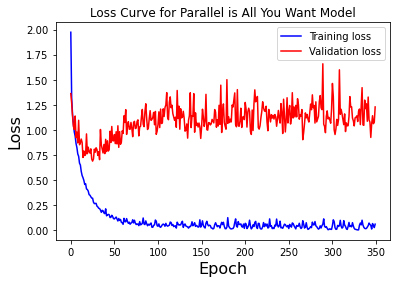

In [167]:
plt.title('Loss Curve for Parallel is All You Want Model')
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.plot(train_losses[:],'b')
plt.plot(valid_losses[:],'r')
plt.legend(['Training loss','Validation loss'])
plt.show()

In [168]:
max=0
for i in range(250):
        # pick load folder  
        load_folder = 'checkpoint'  

        # pick the epoch to load
        x=i+100
        epoch = str(x)
        model_name = f'parallel_all_you_wantFINAL-{epoch}.pkl'

        # make full load path
        load_path = os.path.join(load_folder, model_name)

        ## instantiate empty model and populate with params from binary 
        model = parallel_all_you_want(len(emotions_dict))
        load_checkpoint(optimizer, model, load_path)

        print(f'Loaded model from {load_path}')
        # reinitialize validation function with model from chosen checkpoint
        validate = make_validate_fnc(model,criterion)

        # Convert 4D test feature set array to tensor and move to GPU
        X_test_tensor = torch.tensor(X_test,device=device).float()
        # Convert 4D test label set array to tensor and move to GPU
        y_test_tensor = torch.tensor(y_test,dtype=torch.long,device=device)
        inputs =  X_test_tensor                     # this is what you had
        labels =  y_test_tensor
        #inputs, labels = inputs.cuda(), labels.cuda() # add this line
        # Get the model's performance metrics using the validation function we defined

        #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        #inputs, labels = inputs.to(device), labels.to(device)
        model.to('cuda') 
        inputs = inputs.to('cuda')

        model.to('cuda') 
        labels = labels.to('cuda')

        test_loss, test_acc, predicted_emotions = validate(X_test_tensor,y_test_tensor)
        if test_acc>=max : max=test_acc
        print(f'Test accuracy is {test_acc:.2f}%')
print(f'MAX Test accuracy is {max:.2f}%')

Loaded model from checkpoint/parallel_all_you_wantFINAL-100.pkl
Test accuracy is 74.16%
Loaded model from checkpoint/parallel_all_you_wantFINAL-101.pkl
Test accuracy is 72.73%
Loaded model from checkpoint/parallel_all_you_wantFINAL-102.pkl
Test accuracy is 75.12%
Loaded model from checkpoint/parallel_all_you_wantFINAL-103.pkl
Test accuracy is 72.73%
Loaded model from checkpoint/parallel_all_you_wantFINAL-104.pkl
Test accuracy is 69.38%
Loaded model from checkpoint/parallel_all_you_wantFINAL-105.pkl
Test accuracy is 74.16%
Loaded model from checkpoint/parallel_all_you_wantFINAL-106.pkl
Test accuracy is 71.29%
Loaded model from checkpoint/parallel_all_you_wantFINAL-107.pkl
Test accuracy is 73.21%
Loaded model from checkpoint/parallel_all_you_wantFINAL-108.pkl
Test accuracy is 71.77%
Loaded model from checkpoint/parallel_all_you_wantFINAL-109.pkl
Test accuracy is 71.29%
Loaded model from checkpoint/parallel_all_you_wantFINAL-110.pkl
Test accuracy is 73.68%
Loaded model from checkpoint/par